In [25]:
%cd ..

C:\Users\alexa\Documents


In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from lib.viz import showarray

import os, time, json, io

import logging
logger = logging.getLogger()

import lib.init
from lib.run import find_model, mk_env_agent, nsteps_env_agent
from lib.dashboard import get_episode_dashboard
from lib.pyb.eos3d import EyeOnStickEnv3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import pandas as pd
import seaborn as sns

In [17]:
env_class = EyeOnStickEnv3D
model_name='eos3d.6j-coarse-aim'
model_version = None
gui = False

In [18]:
registered_model = find_model(model_name, model_version=model_version)
print(registered_model)

<ModelVersion: creation_timestamp=1616789697781, current_stage='None', description=None, last_updated_timestamp=1616789697781, name='eos3d.6j-coarse-aim', run_id='e5e61bc4891a495ba6bb2b453c08506d', run_link=None, source='.\\mlruns\\3\\93762e91c9764017912a26bc0ea3bf50\\artifacts\\saved_models/85', status='READY', status_message=None, tags={}, user_id=None, version=145>


In [19]:
nsteps = 150

In [20]:
def run(params, ntargetsposes, gearfuncs, nsteps):
    env, model = mk_env_agent(env_class, registered_model, params, gui=gui)

    df = []
    for tp in range(ntargetsposes):
        env.reset() # random target position and manipulator pose

        target_pos = env.env_method('get_target')[0] # we sample one env
        pose = env.env_method('get_pose')[0]
        #print(f"targetpose {tp} of {ntargetsposes}")

        for (i, (gf_name, gf)) in enumerate(gearfuncs):
            env.env_method('set_gearfunc', gf)
            env.env_method('reset', pose=pose, target_pos=target_pos)

            ninfos = nsteps_env_agent(env, model, nsteps)[3]

            _df = pd.DataFrame(ninfos).assign(gf=gf_name)
            df.append(_df)

    env.close()
    env = model = None
    
    df = pd.concat(df)
    return df

## Experiment 1

In [21]:
gearfuncs = [
    ('lin',  lambda phi: phi),
    ('tanh', lambda phi: np.tanh(phi)),
    ('square', lambda phi: np.square(phi)),
]

palette ={"lin": "green", "tanh": "blue", "square": "orange"}

def run_ex1():
    df = run(params={'NJ': 6, 'NP': 4}, ntargetsposes = 100, gearfuncs=gearfuncs, nsteps=nsteps)
    
    df["alpha"] *= 180 / np.pi
    df["eye_level"] *= 180/np.pi
    
    return df

In [31]:
if False:
    df = run_df()
    df.to_pickle("exp0326\\exp0326-df.pkl")
else:
    df = pd.read_pickle("exp0326\\exp0326-df.pkl")

In [32]:
df

,alpha,eye_level,reward,gf
0,104.490079,80.564389,0,lin
1,104.474186,80.836120,0,lin
2,103.694703,78.671793,0,lin
3,102.147644,75.459833,0,lin
4,99.891591,71.846406,0,lin
...,...,...,...,...
145,63.011428,9.686099,0,square
146,62.321030,10.187579,0,square
147,61.746882,10.396318,0,square
148,61.369426,10.332288,0,square


### доверительный интервал альфы и угла атаки, на 150 шагов

<AxesSubplot:ylabel='alpha'>

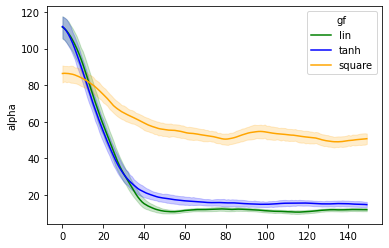

In [33]:
sns.lineplot(x=df.index, y="alpha", hue="gf", palette=palette, data=df)

<AxesSubplot:ylabel='eye_level'>

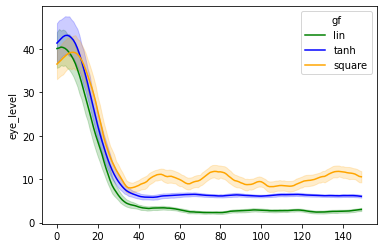

In [34]:
sns.lineplot(x=df.index, y="eye_level", hue="gf", palette=palette, data=df)

### распределение альф в зависимости от типа нелинейности

<AxesSubplot:xlabel='alpha', ylabel='Count'>

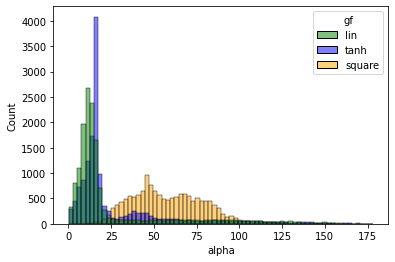

In [35]:
sns.histplot(x="alpha", hue="gf", palette=palette, data=df)

<AxesSubplot:xlabel='gf', ylabel='alpha'>

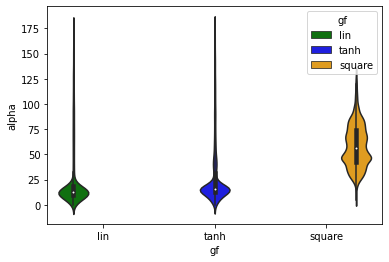

In [36]:
sns.violinplot(x="gf", y="alpha", hue="gf", palette=palette, data=df)

<AxesSubplot:xlabel='gf', ylabel='alpha'>

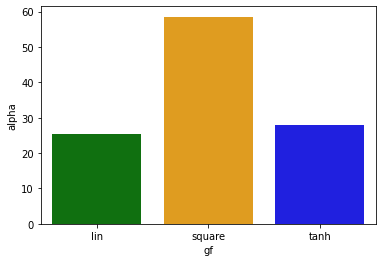

In [37]:
sns.barplot(x="gf", y="alpha", palette=palette, data=pd.DataFrame(df.groupby('gf')['alpha'].mean()).reset_index())

### распределение углов атаки

<AxesSubplot:xlabel='eye_level', ylabel='Count'>

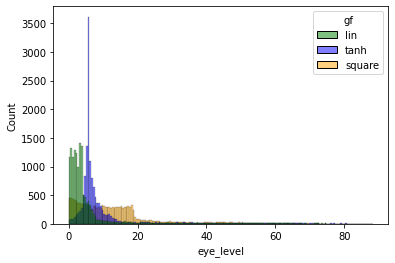

In [38]:
sns.histplot(data=df, x="eye_level", palette=palette, hue="gf")

<AxesSubplot:xlabel='gf', ylabel='eye_level'>

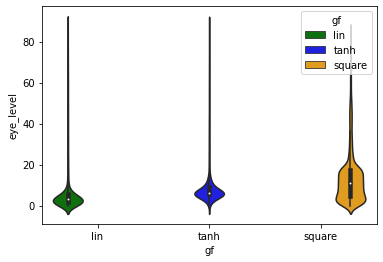

In [39]:
sns.violinplot(x="gf", y="eye_level", palette=palette, hue="gf", data=df)

<AxesSubplot:xlabel='gf', ylabel='eye_level'>

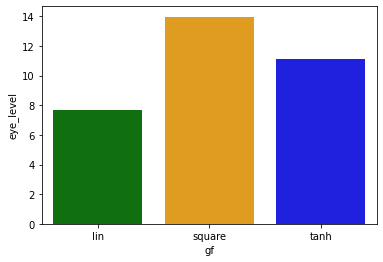

In [40]:
sns.barplot(x="gf", y="eye_level", palette=palette, data=pd.DataFrame(df.groupby('gf')['eye_level'].mean()).reset_index())

### распределение кумулятивной награды по gf

<AxesSubplot:xlabel='gf', ylabel='reward'>

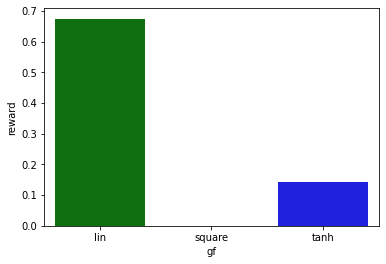

In [54]:
sns.barplot(x="gf", y="reward", palette=palette, data=pd.DataFrame(df.groupby('gf')['reward'].mean()).reset_index())

## Experiment 2

Убираем параболу, добавляем 2 вариации по количеству сегментов

In [42]:
gearfuncs2 = [
    ('lin',  lambda phi: phi),
    ('tanh', lambda phi: np.tanh(phi)),
]

def run_ex2():
    df2 = pd.DataFrame()
    for ns in [1, 2, 4]:
        print('ns=', ns)
        _df = run(params={'NJ': 6, 'NP': ns}, ntargetsposes = 100, gearfuncs=gearfuncs2, nsteps=nsteps)
        df2 = pd.concat((df2, _df.assign(ns=ns)))

    df2["gf*ns"] = df2["gf"] + df2["ns"].astype(str)
    df2["alpha"] *= 180 / np.pi
    df2["eye_level"] *= 180/np.pi
    
    return df2

palette2 = dict(zip(["lin1", "lin2", "lin4", "tanh1", "tanh2", "tanh4"], sns.color_palette("crest")))

In [43]:
if False:
    df2 = run_df()
    df2.to_pickle("exp0326\\exp0326-df2.pkl")
else:
    df2 = pd.read_pickle("exp0326\\exp0326-df2.pkl")

In [44]:
df2

,alpha,eye_level,reward,gf,ns,gf*+ns,gf*ns,gfns
0,143.786504,37.479930,0,lin,1,lin1,lin1,lin1
1,143.866354,35.908103,0,lin,1,lin1,lin1,lin1
2,143.525884,35.452484,0,lin,1,lin1,lin1,lin1
3,142.770613,36.117772,0,lin,1,lin1,lin1,lin1
4,141.601081,37.831846,0,lin,1,lin1,lin1,lin1
...,...,...,...,...,...,...,...,...
145,7.453550,7.657939,0,tanh,4,tanh4,tanh4,tanh4
146,6.557562,7.482108,0,tanh,4,tanh4,tanh4,tanh4
147,5.905248,7.328748,0,tanh,4,tanh4,tanh4,tanh4
148,5.617735,7.232604,0,tanh,4,tanh4,tanh4,tanh4


### доверительный интервал альфы и угла атаки, на 150 шагов

<AxesSubplot:ylabel='alpha'>

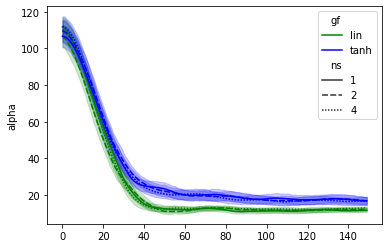

In [45]:
sns.lineplot(x=df2.index, y="alpha", hue="gf", style="ns", palette=palette, data=df2)

<AxesSubplot:ylabel='eye_level'>

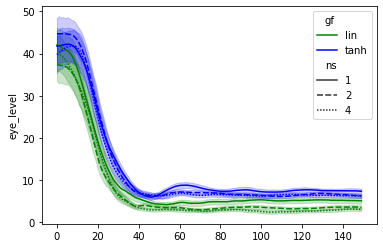

In [46]:
sns.lineplot(x=df2.index, y="eye_level", hue="gf", style="ns", palette=palette, data=df2)

### распределение альф в зависимости от типа нелинейности

<AxesSubplot:xlabel='alpha', ylabel='Count'>

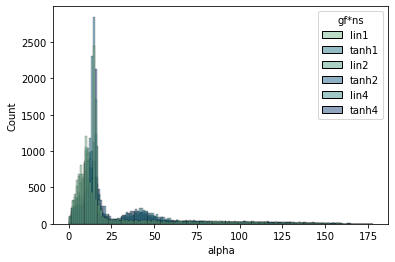

In [47]:
sns.histplot(x="alpha", hue="gf*ns", palette=palette2, data=df2)

<AxesSubplot:xlabel='gf*ns', ylabel='alpha'>

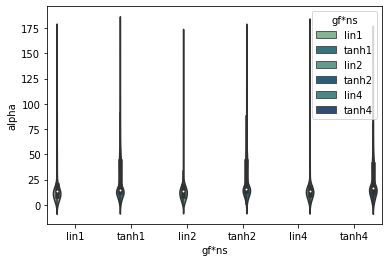

In [48]:
sns.violinplot(x="gf*ns", y="alpha", hue="gf*ns", palette=palette2, data=df2)

<AxesSubplot:xlabel='gf*ns', ylabel='alpha'>

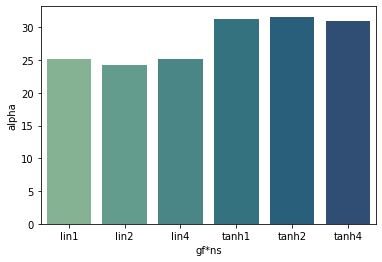

In [49]:
sns.barplot(x="gf*ns", y="alpha", palette=palette2, data=pd.DataFrame(df2.groupby('gf*ns')['alpha'].mean()).reset_index())

### распределение углов атаки

<AxesSubplot:xlabel='eye_level', ylabel='Count'>

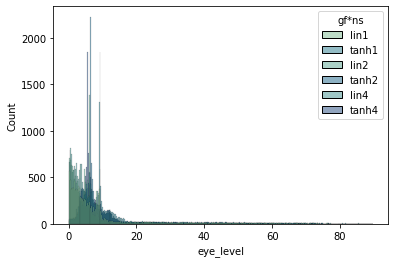

In [50]:
sns.histplot(x="eye_level", hue="gf*ns", palette=palette2, data=df2)

<AxesSubplot:xlabel='gf*ns', ylabel='eye_level'>

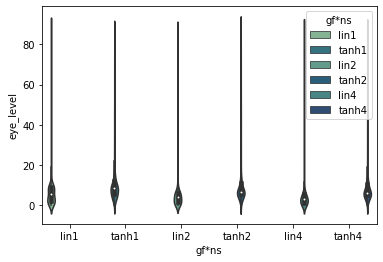

In [51]:
sns.violinplot(x="gf*ns", y="eye_level", hue="gf*ns", palette=palette2, data=df2)

<AxesSubplot:xlabel='gf*ns', ylabel='eye_level'>

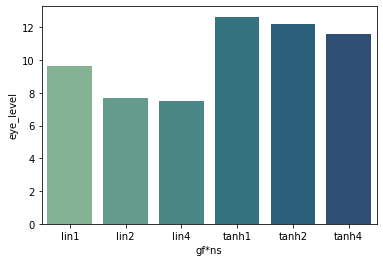

In [52]:
sns.barplot(x="gf*ns", y="eye_level", palette=palette2, data=pd.DataFrame(df2.groupby('gf*ns')['eye_level'].mean()).reset_index())

### распределение кумулятивной награды по gf

<AxesSubplot:xlabel='gf*ns', ylabel='reward'>

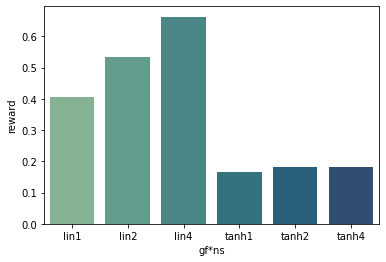

In [53]:
sns.barplot(x="gf*ns", y="reward", palette=palette2, data=pd.DataFrame(df2.groupby('gf*ns')['reward'].mean().reset_index()))